# Implementation of Support Vector Machine for Regression
________
###### 본 튜토리얼에서는, SVM 방법론을 이용한 분류/회귀 문제 해결에 있어 SVR을 이용한 회귀 문제 해결을 주제로 진행.
###### 가장 많이 쓰이는 sklearn에 구현된 방법론은 \varepsilon-SVM으로, 이번 튜토리얼에서는 \varepsilon-insensitive 이외의 Loss Function 설정에 따른 변화를 관찰하고 설명할 것,
________

_________
###### 1) 데이터 생성하기
###### 2) kernel function에 따른 분류 경계면 변화 파악 및 최적의 kernel function 설정 (Linear, Polynomial, RBF)
###### 3) Loss function에 따른 회귀 결과 파악 및 최적의 loss function 설정 (\varepsilon-insensitive , Laplacian, Gaussian, Huber's robust loss, Polynomial, Piecewise polynomial, Pinball_loss)
###### 4) Hyper parameter에 따른 SVR 분류 경계면의 형태 변화 관찰
###### 5) Real dataset에서의 CV를 통한 최적의 SVR 모형 도출
_________

## Import module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cvxpy as cvx
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import time
import warnings
warnings.filterwarnings('ignore')

## 실험 데이터 생성

In [2]:
np.random.seed(1234)                          # 랜덤 생성 seed 고정
X = np.sort(10*np.random.rand(100,1), axis=0) # X : 0-10사이 난수를 100개 생성
y = (-2 + np.log(X) + (3*np.sin(X))).ravel()  # y : sin(X)를 통해 비선형 데이터 생성

y[::5] += 2*(0.5-np.random.rand(20))          # 일부 y값에 NOISE 추가
y[::4] += 3*(0.5-np.random.rand(25))
y[::1] += 1*(0.5-np.random.rand(100))

## kernel function에 따른 변화를 파악 (Linear, Polynomial, RBF)

### Kernel Function

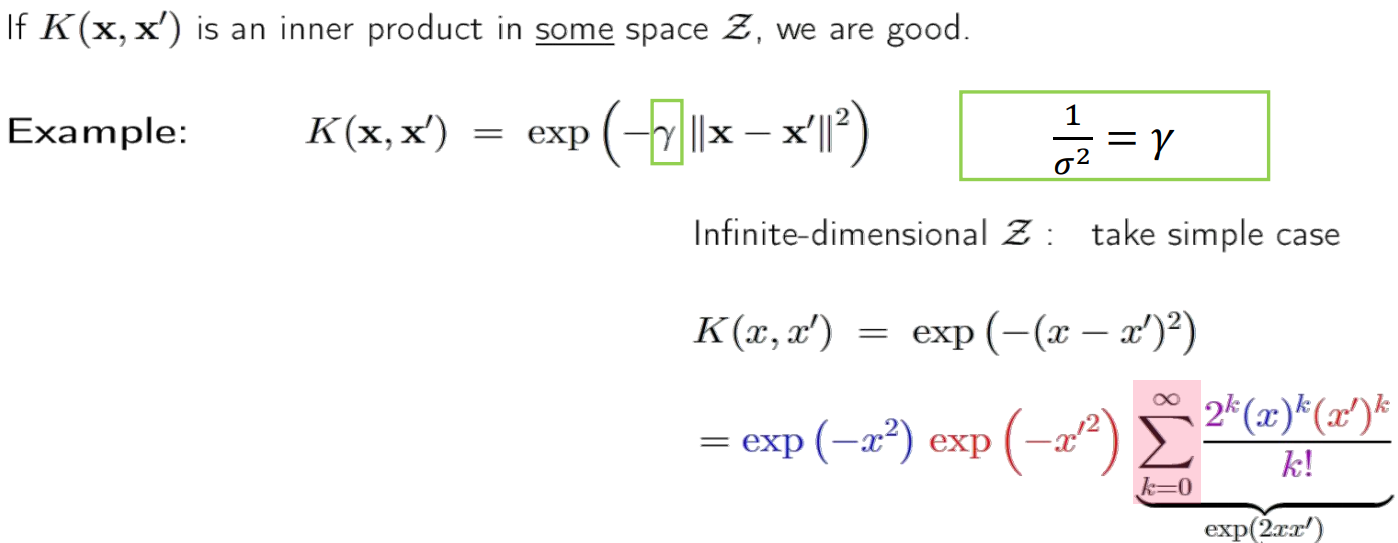

In [3]:
def kernel_f(xi, xj, coef0=1.0, degree=3, gamma=0.1, kernel = None):

    if kernel == 'linear':                                  # Linear kernel
        result = np.dot(xi,xj)+coef0
    elif kernel == 'poly':                                  # Polynomial kernel
        result = (np.dot(xi,xj)+coef0)**degree
    elif kernel == 'rbf':                                   # RBF kernel
        result = np.exp(-gamma*np.linalg.norm(xi-xj)**2)
    elif kernel == 'extended':                              # ExtendedRBF kernel
        result = np.exp(-gamma*np.sqrt(np.dot((xi-xj), (xi-xj).T))**2)
    elif kernel =='sigmoid':                                # Sigmoid kernel
        result = np.tanh(gamma*np.dot(xi,xj)+coef0)
    else:                                                   # Dot product
        result = np.dot(xi,xj)

    return result

### Kernel matrix

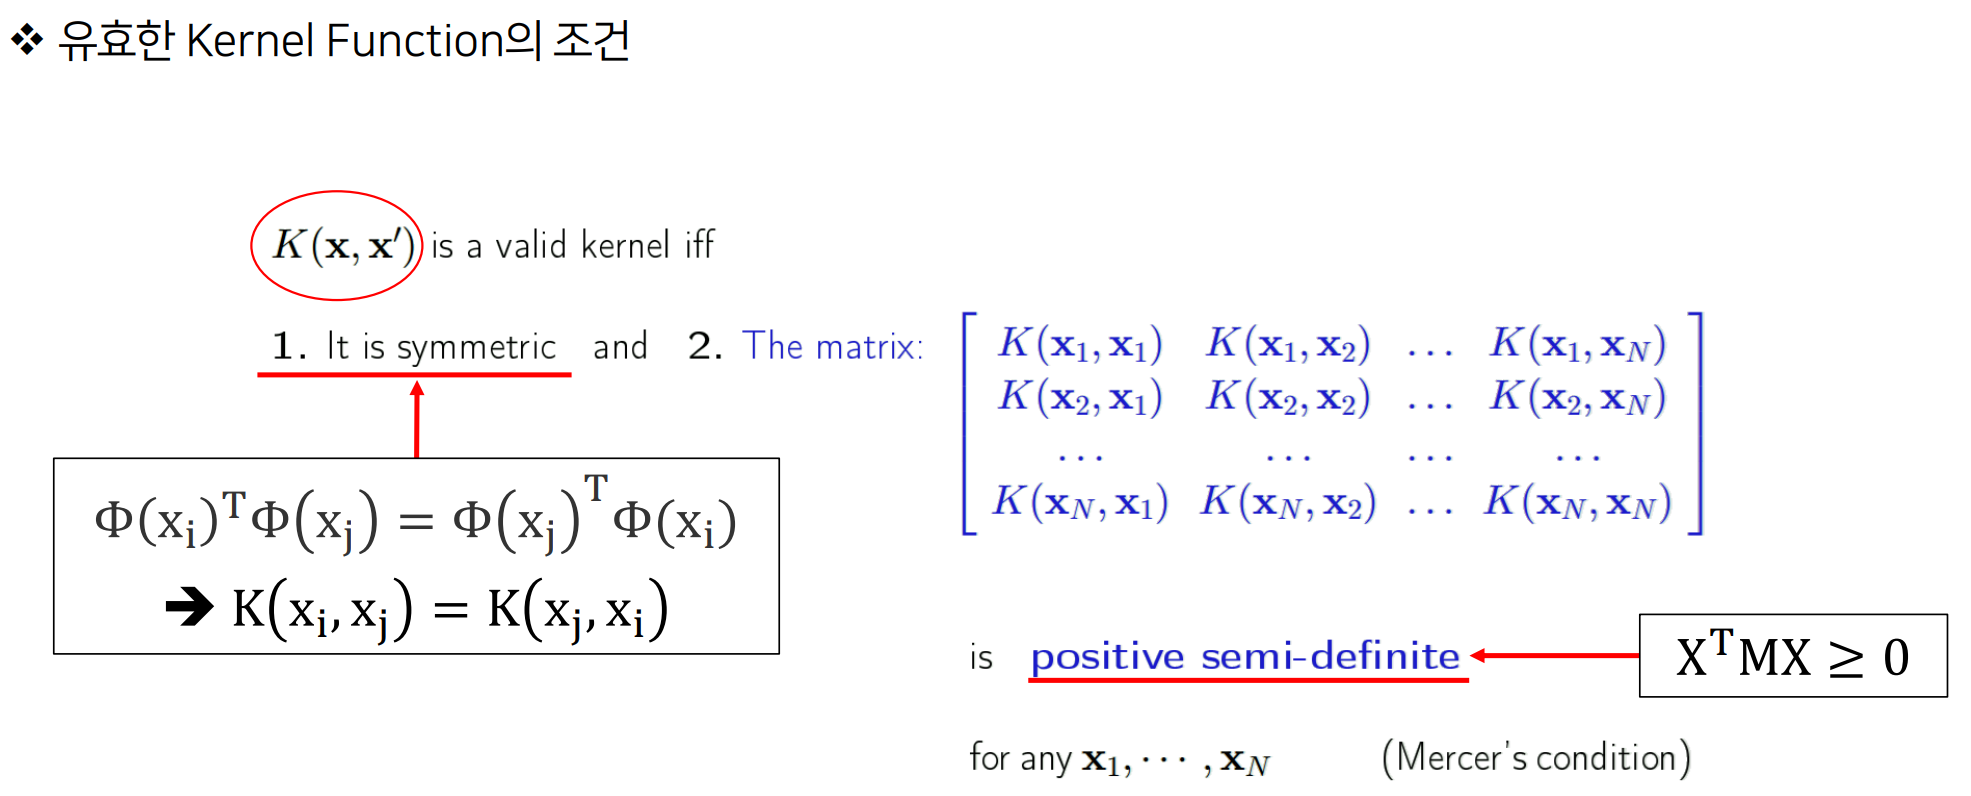

In [4]:
def kernel_matrix(X, kernel, coef0=1.0, degree=3, gamma=0.1):

    X = np.array(X,dtype=np.float64)
    mat = []
    for i in X:
        row = []
        for j in X:
            if kernel=='linear':           
                row.append(kernel_f(i, j, coef0, kernel = 'linear'))
            elif kernel=='poly':
                row.append(kernel_f(i, j, coef0, degree, kernel = 'poly'))
            elif kernel=='rbf':
                row.append(kernel_f(i, j, gamma, kernel = 'rbf'))
            elif kernel=='extended':
                row.append(kernel_f(i, j, gamma, kernel = 'extended'))
            elif kernel=='sigmoid':
                row.append(kernel_f(i, j, coef0, gamma, kernel = 'sigmoid'))    
            else:
                row.append(np.dot(i,j))
        mat.append(row)

    return mat

- kernel function만을 변형시켜 회귀 추정식을 비교 (정확한 비교를 위해 loss function은 \varepsilon-insensitive로, hyper parameter는 (epsilon=0.1, C=10, gamma=0.1)로 고정).

- 육안으로 봐도 RBF kernel을 사용한 회귀분석이 가장 적합한 것을 확인할 수 있고, 이처럼 사용하는 kernel function에 따라 feature space의 특징이 달라지기 때문에 데이터 특성에 적합한 커널함수를 결정하는 것은 중요함.

- 생성 데이터에 적합한 커널함수는 MSE가 가장 낮은 RBF kernel function

In [5]:
svr_lin = SVR(kernel="linear", C=10, gamma=0.1, epsilon=0.1)
svr_poly = SVR(kernel="poly", C=10, gamma=0.1, degree=3, epsilon=0.1)
svr_rbf = SVR(kernel="rbf", C=10, gamma=0.1, epsilon=0.1)

SVR(C=10, gamma=0.1) MES:  0.4288744158008378
SVR(C=10, gamma=0.1) MAPE:  5.371549829069437
SVR(C=10, gamma=0.1) R^2:  0.9124520781087102
SVR(C=10, gamma=0.1, kernel='linear') MES:  4.060743180839941
SVR(C=10, gamma=0.1, kernel='linear') MAPE:  2.834865466687562
SVR(C=10, gamma=0.1, kernel='linear') R^2:  0.17106357078232548
SVR(C=10, gamma=0.1, kernel='poly') MES:  3.81692773667566
SVR(C=10, gamma=0.1, kernel='poly') MAPE:  4.414313776411987
SVR(C=10, gamma=0.1, kernel='poly') R^2:  0.22083463353440402


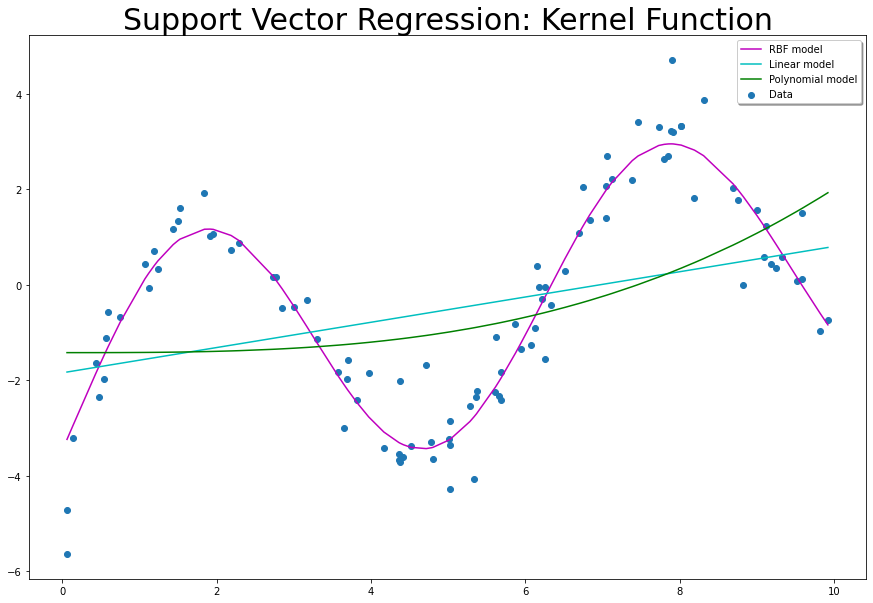

In [6]:
svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ["RBF", "Linear", "Polynomial"]
model_color = ["m", "c", "g"]

plt.figure(figsize=(15, 10))
for ix, svr in enumerate(svrs):
    plt.plot(X, svr.fit(X, y).predict(X), color=model_color[ix], label="{} model".format(kernel_label[ix]))

    mse_loss = mean_squared_error(y, svr.fit(X, y).predict(X))
    mape_loss = mean_absolute_percentage_error(y, svr.fit(X, y).predict(X))

    print(str(svr), 'MES: ', mse_loss)
    print(str(svr), 'MAPE: ', mape_loss)
    print(str(svr), 'R^2: ', svr.fit(X, y).score(X, y))

plt.scatter(X, y, label="Data".format(kernel_label[ix]))
plt.legend(loc="best", ncol=1, fancybox=True, shadow=True)
plt.title("Support Vector Regression: Kernel Function", fontsize=30)
plt.show()

## Hyper parameter에 따른 SVR 분류 경계면의 형태 변화 관찰 (kernel: RBF, loss: \varepsilon-insensitive SVR)

###  오분류 페널티 C의 크기에 따른 분류 경계면의 변화

In [7]:
svr_rbf_1 = SVR(kernel="rbf", C=0.01, gamma='auto', epsilon=0.1)
svr_rbf_2 = SVR(kernel="rbf", C=0.1, gamma='auto', epsilon=0.1)
svr_rbf_3 = SVR(kernel="rbf", C=1, gamma='auto', epsilon=0.1)
svr_rbf_4 = SVR(kernel="rbf", C=10, gamma='auto', epsilon=0.1)

SVR(C=0.01, gamma='auto') MES:  4.422404088552323
SVR(C=0.01, gamma='auto') MAPE:  1.4536993181640065
SVR(C=0.01, gamma='auto') R^2:  0.09723622241878915
SVR(C=0.1, gamma='auto') MES:  1.7402940350914238
SVR(C=0.1, gamma='auto') MAPE:  2.4986339395591917
SVR(C=0.1, gamma='auto') R^2:  0.644746525698995
SVR(C=1, gamma='auto') MES:  0.47948429326640996
SVR(C=1, gamma='auto') MAPE:  4.633337910071697
SVR(C=1, gamma='auto') R^2:  0.9021208728979493
SVR(C=10, gamma='auto') MES:  0.3548546616916606
SVR(C=10, gamma='auto') MAPE:  4.691820890631881
SVR(C=10, gamma='auto') R^2:  0.9275620390026519


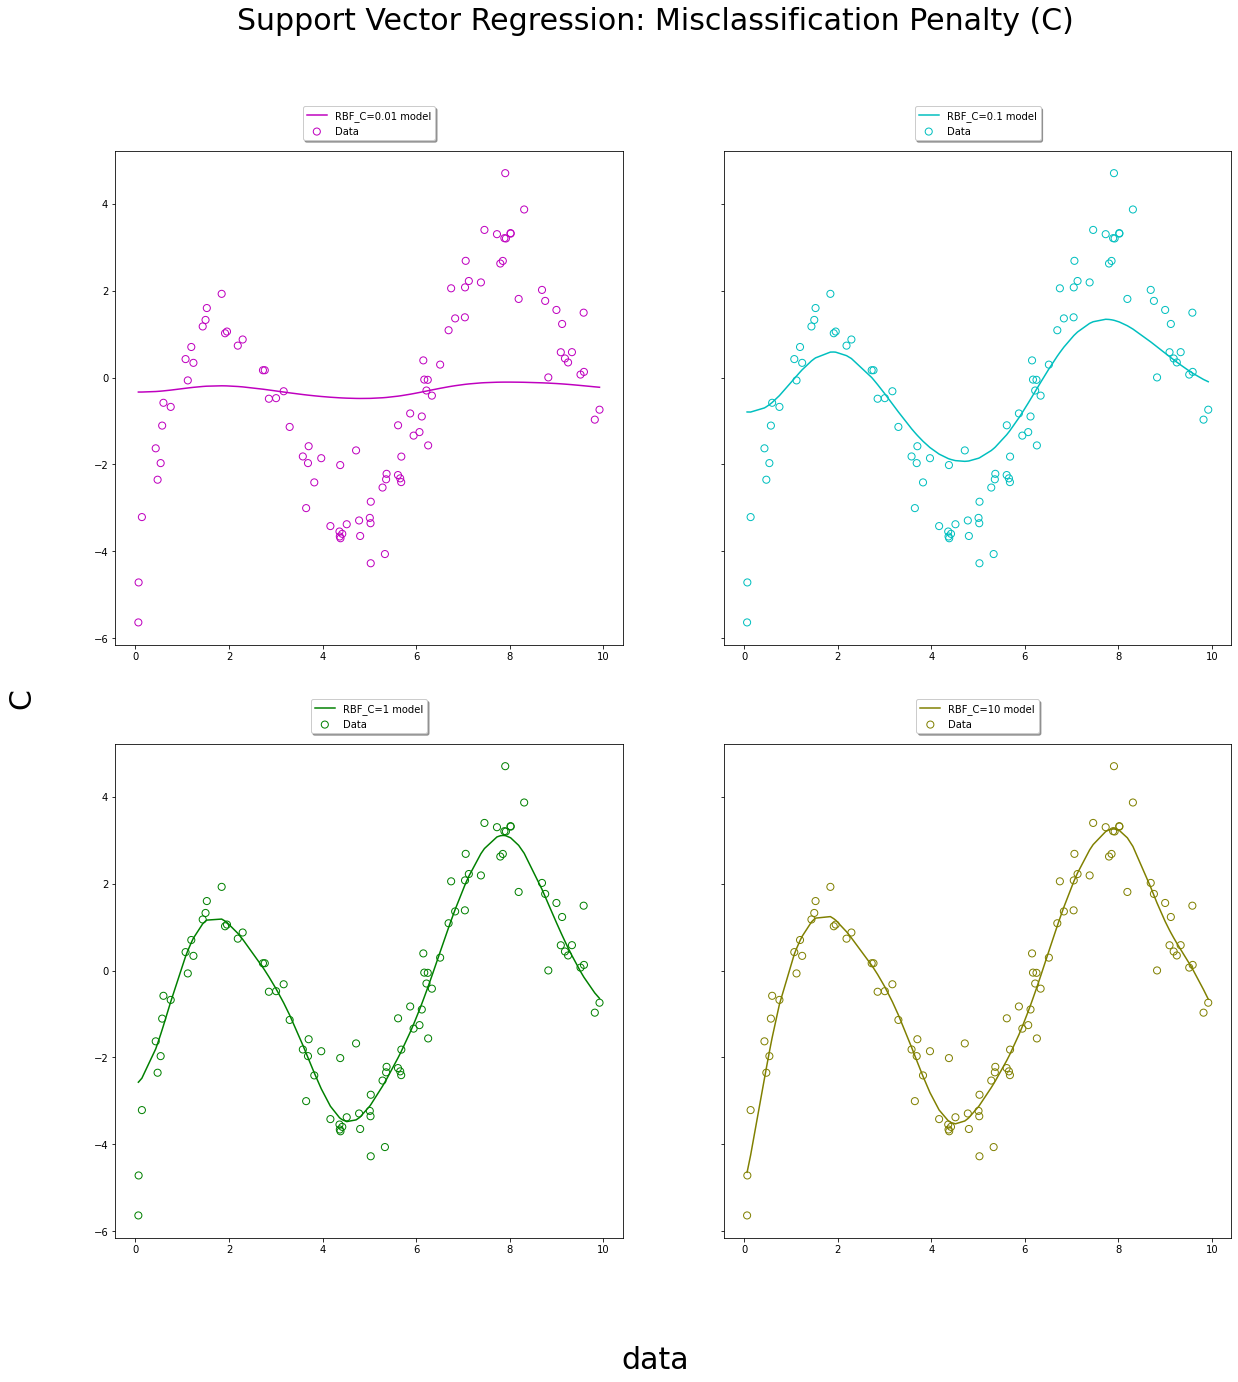

In [8]:
svrs = [svr_rbf_1, svr_rbf_2, svr_rbf_3, svr_rbf_4]
kernel_label = ["RBF_C=0.01", "RBF_C=0.1", "RBF_C=1", "RBF_C=10"]
model_color = ["m", "c", "g", "olive"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20), sharey=True)
for ix, svr in enumerate(svrs):
    if ix == 0:
        axes[0, 0].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], label="{} model".format(kernel_label[ix]))
        axes[0, 0].scatter(X, y, facecolor="none", edgecolor=model_color[ix], s=50, label="Data".format(kernel_label[ix]))
        axes[0, 0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)
        
        mse_loss = mean_squared_error(y, svr.fit(X, y).predict(X))
        mape_loss = mean_absolute_percentage_error(y, svr.fit(X, y).predict(X))

        print(str(svr), 'MES: ', mse_loss)
        print(str(svr), 'MAPE: ', mape_loss)
        print(str(svr), 'R^2: ', svr.fit(X, y).score(X, y))
    
    elif ix == 1:
        axes[0, 1].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], label="{} model".format(kernel_label[ix]))
        axes[0, 1].scatter(X, y, facecolor="none", edgecolor=model_color[ix], s=50, label="Data".format(kernel_label[ix]))
        axes[0, 1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)
    
        mse_loss = mean_squared_error(y, svr.fit(X, y).predict(X))
        mape_loss = mean_absolute_percentage_error(y, svr.fit(X, y).predict(X))

        print(str(svr), 'MES: ', mse_loss)
        print(str(svr), 'MAPE: ', mape_loss)
        print(str(svr), 'R^2: ', svr.fit(X, y).score(X, y))
        
    elif ix == 2:
        axes[1, 0].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], label="{} model".format(kernel_label[ix]))
        axes[1, 0].scatter(X, y, facecolor="none", edgecolor=model_color[ix], s=50, label="Data".format(kernel_label[ix]))
        axes[1, 0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)
        
        mse_loss = mean_squared_error(y, svr.fit(X, y).predict(X))
        mape_loss = mean_absolute_percentage_error(y, svr.fit(X, y).predict(X))

        print(str(svr), 'MES: ', mse_loss)
        print(str(svr), 'MAPE: ', mape_loss)
        print(str(svr), 'R^2: ', svr.fit(X, y).score(X, y))
    
    else:
        axes[1, 1].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], label="{} model".format(kernel_label[ix]))
        axes[1, 1].scatter(X, y, facecolor="none", edgecolor=model_color[ix], s=50, label="Data".format(kernel_label[ix]))
        axes[1, 1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)
        
        mse_loss = mean_squared_error(y, svr.fit(X, y).predict(X))
        mape_loss = mean_absolute_percentage_error(y, svr.fit(X, y).predict(X))

        print(str(svr), 'MES: ', mse_loss)
        print(str(svr), 'MAPE: ', mape_loss)
        print(str(svr), 'R^2: ', svr.fit(X, y).score(X, y))

fig.text(0.5, 0.04, "data", ha="center", va="center", fontsize=30)
fig.text(0.06, 0.5, "C", ha="center", va="center", rotation="vertical", fontsize=30)
fig.suptitle("Support Vector Regression: Misclassification Penalty (C)", fontsize=30)
plt.show()

- C 값이 작아질수록 추정식이 선형에 가까워 지는것을 확인

### $\varepsilon$의 크기에 따른 분류 경계면의 변화

In [9]:
svr_rbf_1 = SVR(kernel="rbf", C=0.1, gamma='auto', epsilon=1)
svr_rbf_2 = SVR(kernel="rbf", C=0.1, gamma='auto', epsilon=2)
svr_rbf_3 = SVR(kernel="rbf", C=0.1, gamma='auto', epsilon=5)
svr_rbf_4 = SVR(kernel="rbf", C=0.1, gamma='auto', epsilon=10)

SVR(C=0.1, epsilon=1, gamma='auto') MES:  2.1977588120799347
SVR(C=0.1, epsilon=1, gamma='auto') MAPE:  2.145410611500473
SVR(C=0.1, epsilon=1, gamma='auto') R^2:  0.5513623342241529
SVR(C=0.1, epsilon=2, gamma='auto') MES:  3.0224831622879615
SVR(C=0.1, epsilon=2, gamma='auto') MAPE:  1.378332030643332
SVR(C=0.1, epsilon=2, gamma='auto') R^2:  0.38300791546258506
SVR(C=0.1, epsilon=5, gamma='auto') MES:  4.772672964704273
SVR(C=0.1, epsilon=5, gamma='auto') MAPE:  2.4876628607889053
SVR(C=0.1, epsilon=5, gamma='auto') R^2:  0.02573437693556202
SVR(C=0.1, epsilon=10, gamma='auto') MES:  4.904301024693577
SVR(C=0.1, epsilon=10, gamma='auto') MAPE:  2.6102197969367493
SVR(C=0.1, epsilon=10, gamma='auto') R^2:  -0.0011354075283287468


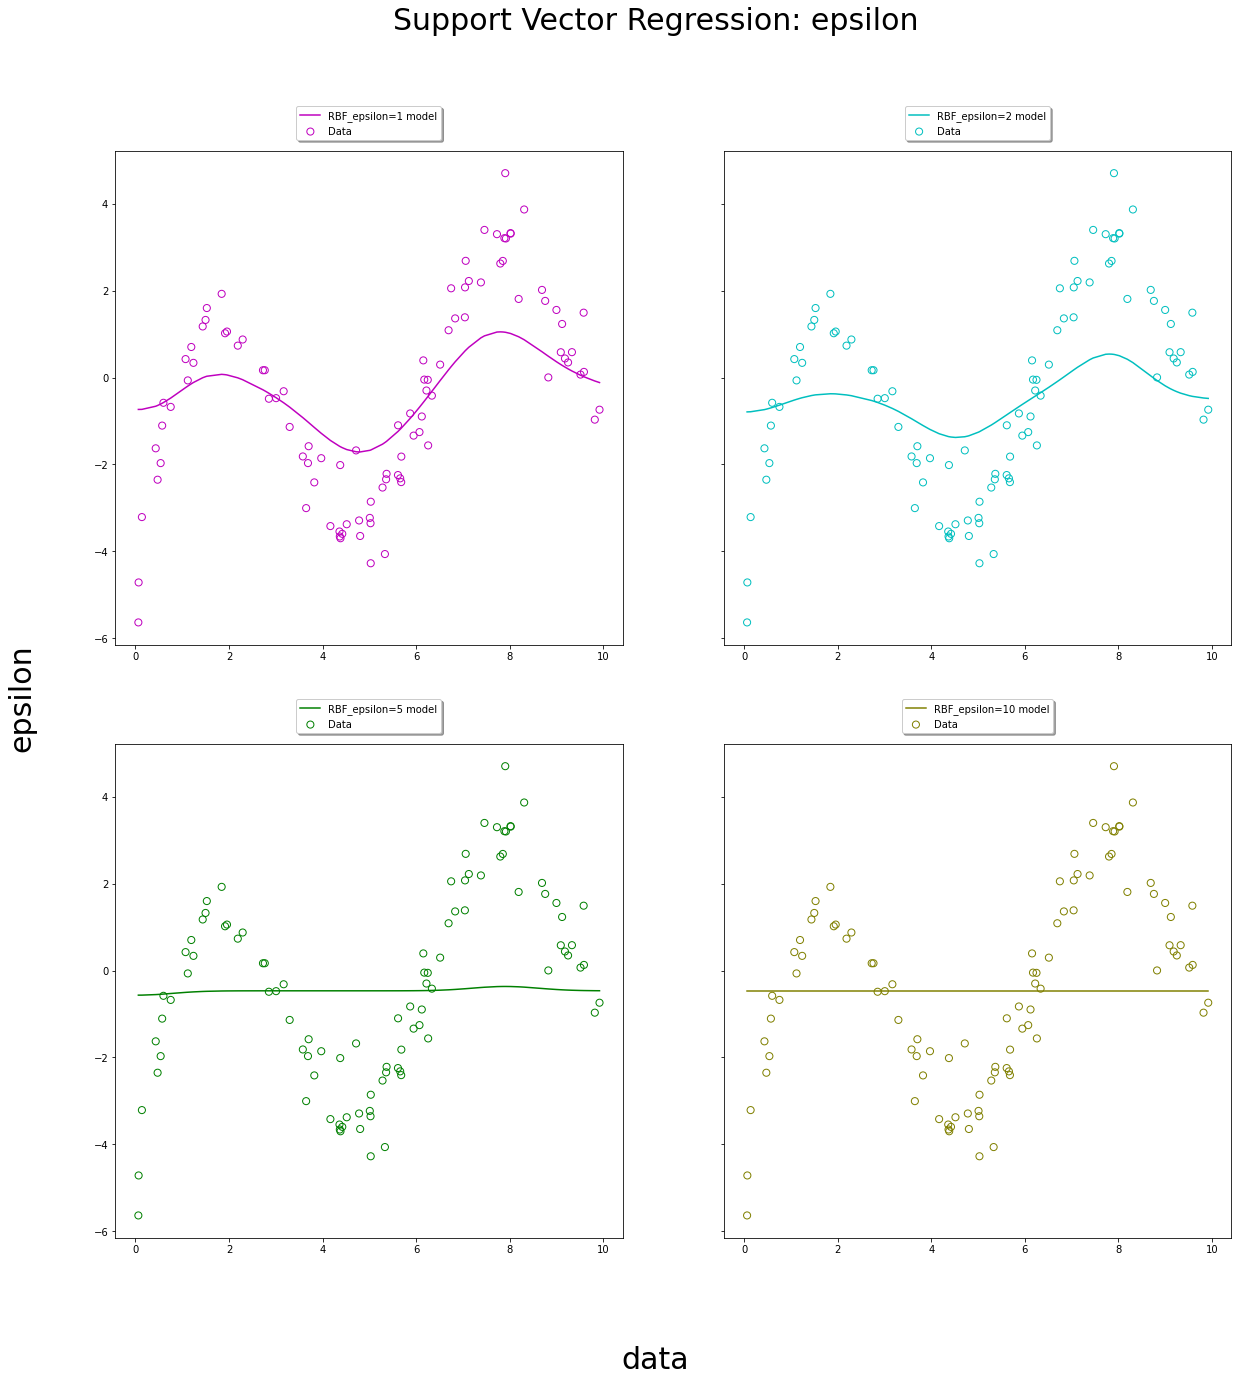

In [10]:
svrs = [svr_rbf_1, svr_rbf_2, svr_rbf_3, svr_rbf_4]
kernel_label = ["RBF_epsilon=1", "RBF_epsilon=2", "RBF_epsilon=5", "RBF_epsilon=10"]
model_color = ["m", "c", "g", "olive"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20), sharey=True)
for ix, svr in enumerate(svrs):
    if ix == 0:
        axes[0, 0].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], label="{} model".format(kernel_label[ix]))
        axes[0, 0].scatter(X, y, facecolor="none", edgecolor=model_color[ix], s=50, label="Data".format(kernel_label[ix]))
        axes[0, 0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)
        
        mse_loss = mean_squared_error(y, svr.fit(X, y).predict(X))
        mape_loss = mean_absolute_percentage_error(y, svr.fit(X, y).predict(X))

        print(str(svr), 'MES: ', mse_loss)
        print(str(svr), 'MAPE: ', mape_loss)
        print(str(svr), 'R^2: ', svr.fit(X, y).score(X, y))
        
    elif ix == 1:
        axes[0, 1].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], label="{} model".format(kernel_label[ix]))
        axes[0, 1].scatter(X, y, facecolor="none", edgecolor=model_color[ix], s=50, label="Data".format(kernel_label[ix]))
        axes[0, 1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)
        
        mse_loss = mean_squared_error(y, svr.fit(X, y).predict(X))
        mape_loss = mean_absolute_percentage_error(y, svr.fit(X, y).predict(X))

        print(str(svr), 'MES: ', mse_loss)
        print(str(svr), 'MAPE: ', mape_loss)
        print(str(svr), 'R^2: ', svr.fit(X, y).score(X, y))
        
    elif ix == 2:
        axes[1, 0].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], label="{} model".format(kernel_label[ix]))
        axes[1, 0].scatter(X, y, facecolor="none", edgecolor=model_color[ix], s=50, label="Data".format(kernel_label[ix]))
        axes[1, 0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)
        
        mse_loss = mean_squared_error(y, svr.fit(X, y).predict(X))
        mape_loss = mean_absolute_percentage_error(y, svr.fit(X, y).predict(X))

        print(str(svr), 'MES: ', mse_loss)
        print(str(svr), 'MAPE: ', mape_loss)
        print(str(svr), 'R^2: ', svr.fit(X, y).score(X, y))
        
    else:
        axes[1, 1].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], label="{} model".format(kernel_label[ix]))
        axes[1, 1].scatter(X, y, facecolor="none", edgecolor=model_color[ix], s=50, label="Data".format(kernel_label[ix]))
        axes[1, 1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)
        
        mse_loss = mean_squared_error(y, svr.fit(X, y).predict(X))
        mape_loss = mean_absolute_percentage_error(y, svr.fit(X, y).predict(X))

        print(str(svr), 'MES: ', mse_loss)
        print(str(svr), 'MAPE: ', mape_loss)
        print(str(svr), 'R^2: ', svr.fit(X, y).score(X, y))

fig.text(0.5, 0.04, "data", ha="center", va="center", fontsize=30)
fig.text(0.06, 0.5, "epsilon", ha="center", va="center", rotation="vertical", fontsize=30)
fig.suptitle("Support Vector Regression: epsilon", fontsize=30)
plt.show()

- $\varepsilon$의 크기가 커질수록 추정식이 선형에 가까워짐을 확인

### $\gamma$의 크기에 따른 분류 경계면의 변화

In [11]:
svr_rbf_1 = SVR(kernel="rbf", C=0.1, gamma=0.1, epsilon=0.1)
svr_rbf_2 = SVR(kernel="rbf", C=0.1, gamma=1, epsilon=0.1)
svr_rbf_3 = SVR(kernel="rbf", C=0.1, gamma=5, epsilon=0.1)
svr_rbf_4 = SVR(kernel="rbf", C=0.1, gamma=10, epsilon=0.1)

SVR(C=0.1, gamma=0.1) MES:  3.05518673003662
SVR(C=0.1, gamma=0.1) MAPE:  2.8278695587440548
SVR(C=0.1, gamma=0.1) R^2:  0.37633199988137755
SVR(C=0.1, gamma=1) MES:  1.7402940350914238
SVR(C=0.1, gamma=1) MAPE:  2.4986339395591917
SVR(C=0.1, gamma=1) R^2:  0.644746525698995
SVR(C=0.1, gamma=5) MES:  2.650355558096282
SVR(C=0.1, gamma=5) MAPE:  1.210981504879324
SVR(C=0.1, gamma=5) R^2:  0.45897187419985586
SVR(C=0.1, gamma=10) MES:  3.07782264697016
SVR(C=0.1, gamma=10) MAPE:  1.120965040382895
SVR(C=0.1, gamma=10) R^2:  0.37171123581939736


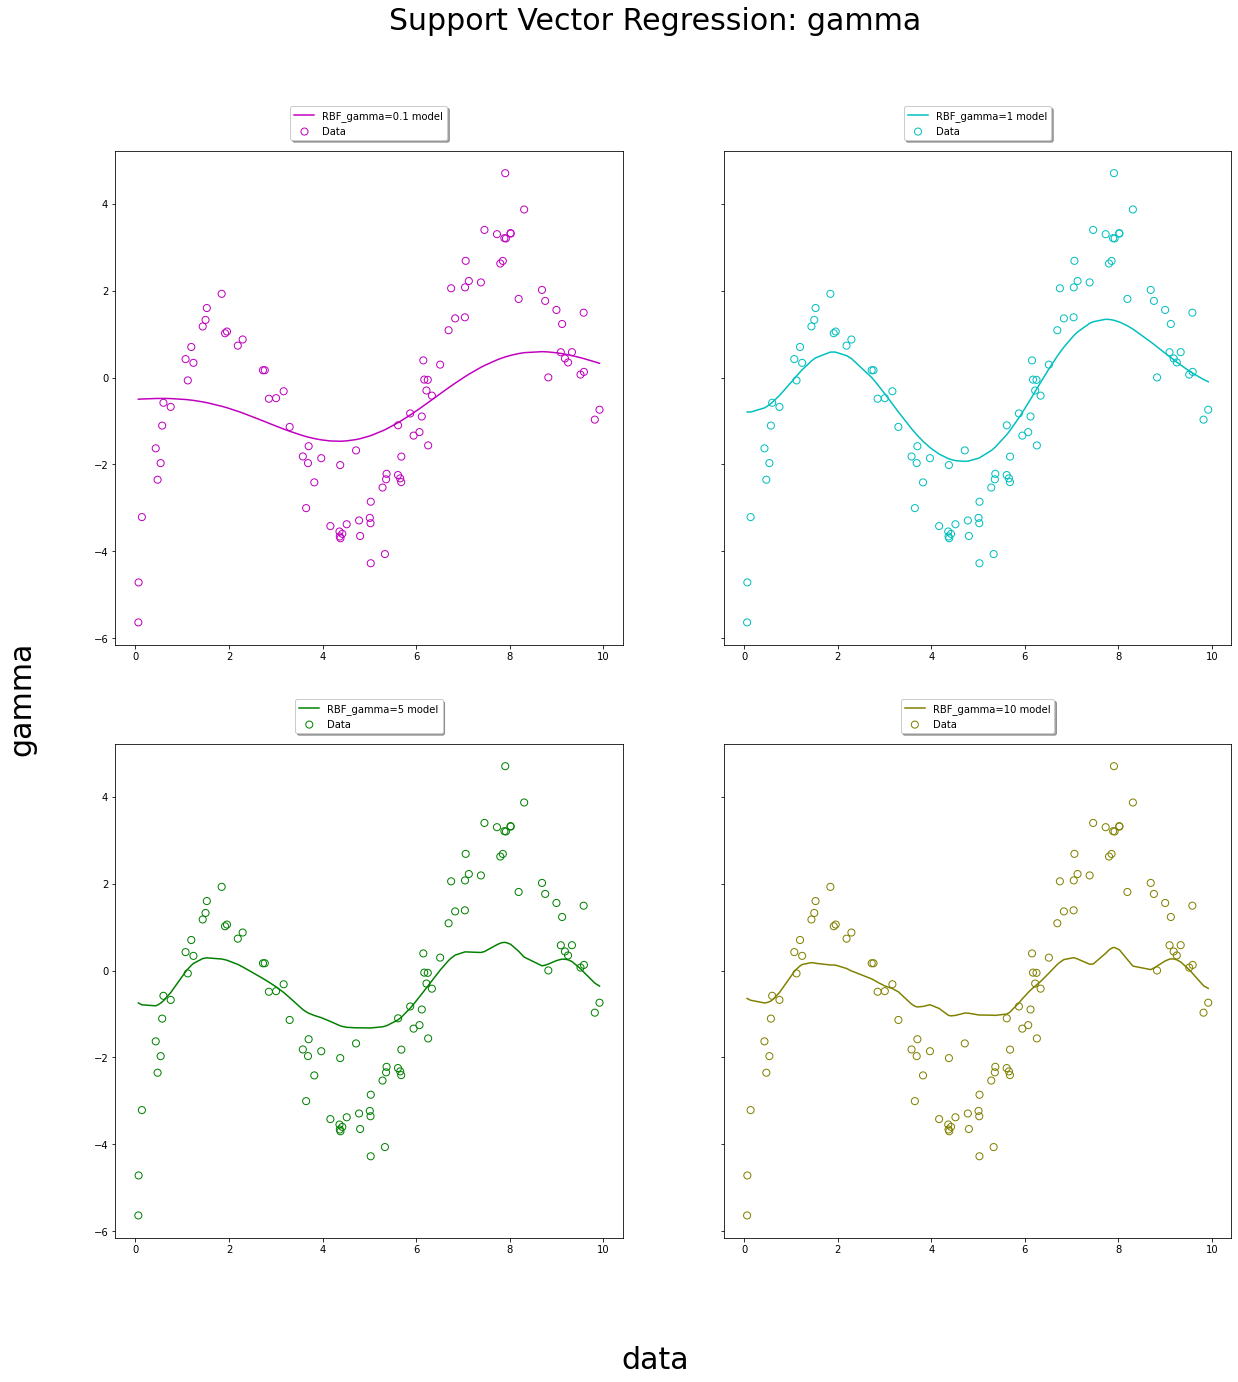

In [12]:
svrs = [svr_rbf_1, svr_rbf_2, svr_rbf_3, svr_rbf_4]
kernel_label = ["RBF_gamma=0.1", "RBF_gamma=1", "RBF_gamma=5", "RBF_gamma=10"]
model_color = ["m", "c", "g", "olive"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20), sharey=True)
for ix, svr in enumerate(svrs):
    if ix == 0:
        axes[0, 0].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], label="{} model".format(kernel_label[ix]))
        axes[0, 0].scatter(X, y, facecolor="none", edgecolor=model_color[ix], s=50, label="Data".format(kernel_label[ix]))
        axes[0, 0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)
        
        mse_loss = mean_squared_error(y, svr.fit(X, y).predict(X))
        mape_loss = mean_absolute_percentage_error(y, svr.fit(X, y).predict(X))

        print(str(svr), 'MES: ', mse_loss)
        print(str(svr), 'MAPE: ', mape_loss)
        print(str(svr), 'R^2: ', svr.fit(X, y).score(X, y))
        
    elif ix == 1:
        axes[0, 1].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], label="{} model".format(kernel_label[ix]))
        axes[0, 1].scatter(X, y, facecolor="none", edgecolor=model_color[ix], s=50, label="Data".format(kernel_label[ix]))
        axes[0, 1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)
        
        mse_loss = mean_squared_error(y, svr.fit(X, y).predict(X))
        mape_loss = mean_absolute_percentage_error(y, svr.fit(X, y).predict(X))

        print(str(svr), 'MES: ', mse_loss)
        print(str(svr), 'MAPE: ', mape_loss)
        print(str(svr), 'R^2: ', svr.fit(X, y).score(X, y))
        
    elif ix == 2:
        axes[1, 0].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], label="{} model".format(kernel_label[ix]))
        axes[1, 0].scatter(X, y, facecolor="none", edgecolor=model_color[ix], s=50, label="Data".format(kernel_label[ix]))
        axes[1, 0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)
        
        mse_loss = mean_squared_error(y, svr.fit(X, y).predict(X))
        mape_loss = mean_absolute_percentage_error(y, svr.fit(X, y).predict(X))

        print(str(svr), 'MES: ', mse_loss)
        print(str(svr), 'MAPE: ', mape_loss)
        print(str(svr), 'R^2: ', svr.fit(X, y).score(X, y))
        
    else:
        axes[1, 1].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], label="{} model".format(kernel_label[ix]))
        axes[1, 1].scatter(X, y, facecolor="none", edgecolor=model_color[ix], s=50, label="Data".format(kernel_label[ix]))
        axes[1, 1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)
        
        mse_loss = mean_squared_error(y, svr.fit(X, y).predict(X))
        mape_loss = mean_absolute_percentage_error(y, svr.fit(X, y).predict(X))

        print(str(svr), 'MES: ', mse_loss)
        print(str(svr), 'MAPE: ', mape_loss)
        print(str(svr), 'R^2: ', svr.fit(X, y).score(X, y))

fig.text(0.5, 0.04, "data", ha="center", va="center", fontsize=30)
fig.text(0.06, 0.5, "gamma", ha="center", va="center", rotation="vertical", fontsize=30)
fig.suptitle("Support Vector Regression: gamma", fontsize=30)
plt.show()

- $\gamma$가 커질수록 더 피팅하려는 모습처럼 보이는데 매우 크게 하면 과적합이 될 수도 있을 것 같다는 생각을 함.

## Loss function에 따른 회귀 결과 파악 및 최적의 loss function 설정 (\varepsilon-insensitive , Laplacian, Gaussian, Huber's robust loss, Polynomial, Piecewise polynomial, Pinball_loss)

- 기본적으로 sklearn에서 제공하는 SVR은 ϵ-insensitive 함수를 기반으로 진행되며, 이를 제외하고도 다양한 loss function으로 변형하여 사용할 수 있음.


- 아래 표에서 볼 수 있듯 Gaussian, Polynomial 이외에도 다양한 함수가 존재함 (추가로 강의에서 다루지 않은 Pinball loss를 정의).

- 각 loss function의 파라미터 변화에 따라 loss값의 개형이 어떻게 변하는지 각각 비교 (하이퍼파라미터: [C : cost , E : epsilon , P : degree , S : σ(sigma)])

- ϵ-insensitive loss function

In [13]:
# Epsilon - insensitive loss
def eps_loss(t, c=3, e=5):
    return (abs(t)<e)*0*abs(t) + ((t)>=e)*c*abs(t-e) + ((t)<-e)*c*abs(t+e)

- Laplacian loss function

In [14]:
# Laplacian loss
def laplacian_loss(t, c=3):
    return c*abs(t)

- Gaussian loss function

In [15]:
# Gaussian loss
def gaussian_loss(t, c=3):
    return c*0.5*t**2

- Huber loss function

In [16]:
# Huber loss
def huber_loss(t, c=3, s=5):
    return c*((abs(t)<s)*(0.5/s)*(t**2) + (abs(t)>=s)*(abs(t)-s/2))

- Polynomial loss function

In [17]:
# Polynomial loss
def poly_loss(t, c=3, p=3):
    return c*((p**-1)*abs(t)**p)

- Piecewise loss function

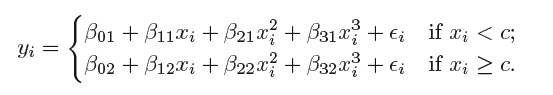

In [18]:
# Piecewise polynomial
def picewise_polynomial_loss(t, c=3, s=5, p=3):
    return c*( (abs(t) <= s)*((abs(t)**p)/p/(s*(p-1))) + (abs(t) > s)*(abs(t)-(s*(p-1))/p) )

- Pinball loss function

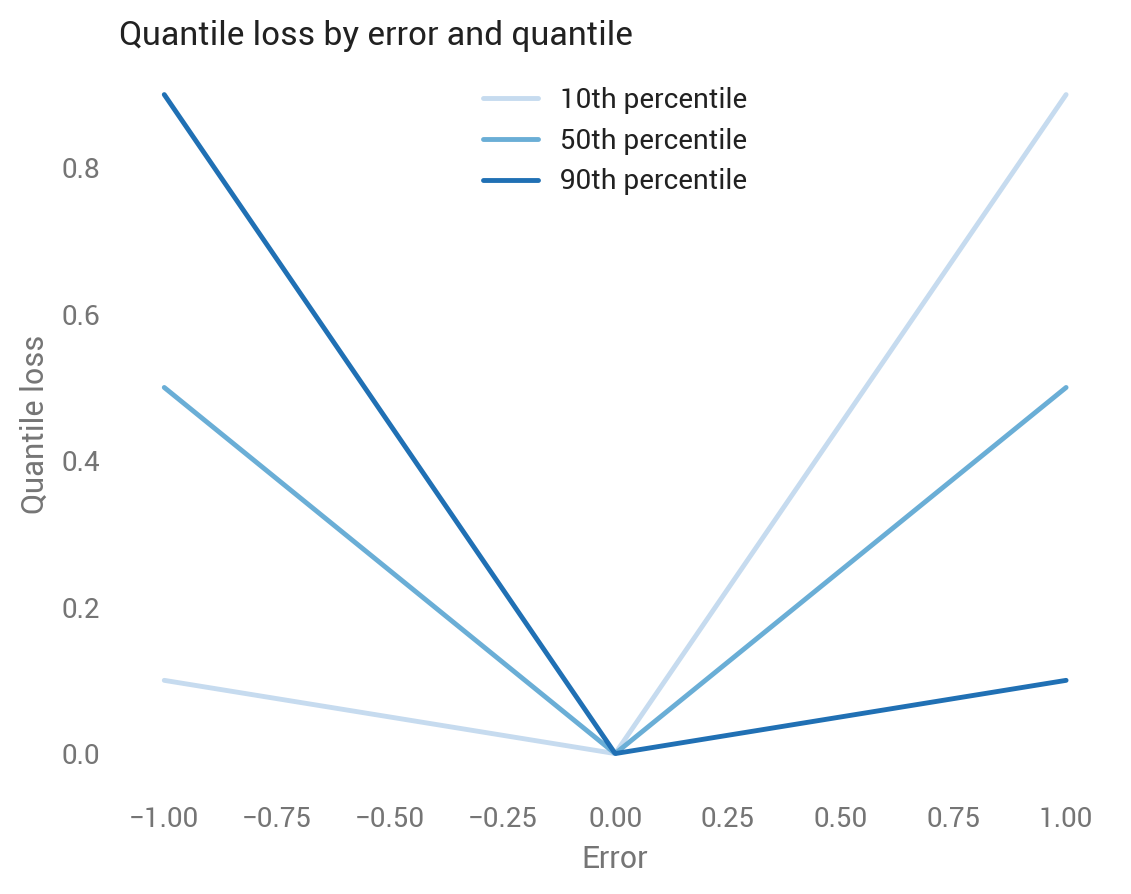

In [19]:
# Pinball loss
def pinball_loss(t, c=3, tau=0.95): #tau: target quantile
    return c*(((t)>=0)*t + ((t)<0)*t*-tau)

- 아래 코드에서 사용한 parameter의 이름은 sklearn에서 제공하는 SVR 함수의 parameter name과 default 값으로 일치.

- loss: ['epsilon-insensitive', 'huber', 'laplacian', 'gaussian', 'polynomial', 'piecewise_polynomial', 'pinball'] defualt: epsilon-insensitive
- kernel: [None, 'linear', 'poly', 'rbf', 'extended', 'sigmoid'] # extended = ExtendedRBF
- coef0: Independent term in kernel function. in 'linear','poly'
- degree: Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
- gamma: Kernel coefficient for ‘rbf’, ‘poly’
        if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
        if ‘auto’, uses 1 / n_features.
- p: polynomial/'piecewise_polynomial loss function p
- sigma: for other loss function
- C: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.

In [20]:
class customSVR:
    def __init__(self, loss='epsilon-insensitive', C=1.0, epsilon=0.1, kernel=None, coef0=0.0, degree=3, gamma=0.1, p=3, sigma=0.1, tau=0.95):
        self.loss = loss
        self.kernel = kernel
        self.C = C
        self.epsilon = epsilon
        self.coef0 = coef0
        self.degree = degree
        self.gamma = gamma
        self.sigma = sigma
        self.p = p
        self.tau = tau

    # model fitting
    def fit(self, X, y):
        self.X = X
        self.y = y

        n = self.X.shape[0]  # numper of instances

        # variable for dual optimization problem
        alpha = cvx.Variable(n)
        alpha_ = cvx.Variable(n)
        one_vec = np.ones(n)

        #object function and constraints of all types of loss fuction
        if self.loss == 'huber':
            self.constraints = []
            self.svr_obj = cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_, kernel_matrix(self.X, kernel=self.kernel, coef0=self.coef0, degree=self.degree, gamma=self.gamma)) - self.epsilon*one_vec*(alpha+alpha_) + self.y*(alpha-alpha_) - self.sigma/(2*self.C)*one_vec*(cvx.power(alpha, 2) + cvx.power(alpha_, 2)))
            self.constraints += [cvx.sum(one_vec*alpha - one_vec*alpha_) == 0]
            for i in range(n):
                self.constraints += [alpha[i] >= 0, alpha_[i] >= 0]
            svr = cvx.Problem(self.svr_obj, self.constraints)
            svr.solve()

            # alpha & alpha_
            self.a = np.array(alpha.value).flatten()
            self.a_ = np.array(alpha_.value).flatten()

            #compute b
            idx = np.where((np.array(alpha.value).ravel() < self.C-1E-10) * (np.array(alpha.value).ravel() > 1E-10))[0][0]
            self.b = -self.epsilon + self.y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*kernel_f(self.X[idx], self.X[i], kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)])

        elif self.loss == 'laplacian': # epsilon = 0 of epsilon-insensitive
            self.constraints = []
            self.svr_obj = cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_, kernel_matrix(self.X,kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma)) + self.y*(alpha-alpha_))
            self.constraints += [cvx.sum(one_vec*alpha - one_vec*alpha_) == 0]
            for i in range(n):
                self.constraints += [alpha[i] >= 0, alpha_[i] >=0, alpha[i] <= self.C, alpha_[i] <= self.C]
            svr = cvx.Problem(self.svr_obj, self.constraints)
            svr.solve()

            #alpha & alpha_
            self.a = np.array(alpha.value).flatten()
            self.a_ = np.array(alpha_.value).flatten()

            #compute b
            idx = np.where((np.array(alpha.value).ravel() < self.C-1E-10) * (np.array(alpha.value).ravel() > 1E-10))[0][0]
            self.b = -self.epsilon + self.y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*kernel_f(self.X[idx], self.X[i], kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)])

        elif self.loss == 'gaussian': # sigma = 1 of huber
            self.constraints = []
            self.svr_obj = cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_, kernel_matrix(self.X,kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma)) - self.epsilon*one_vec*(alpha+alpha_) + self.y*(alpha-alpha_) - 1./(2*self.C)*one_vec*(cvx.power(alpha, 2) + cvx.power(alpha_, 2)))
            self.constraints += [cvx.sum(one_vec*alpha - one_vec*alpha_) == 0]
            for i in range(n):
                self.constraints += [alpha[i] >= 0, alpha_[i] >=0]
            svr = cvx.Problem(self.svr_obj,self.constraints)
            svr.solve()

            #alpha & alpha_
            self.a = np.array(alpha.value).flatten()
            self.a_ = np.array(alpha_.value).flatten()

            #compute b
            idx = np.where((np.array(alpha.value).ravel() < self.C-1E-10) * (np.array(alpha.value).ravel() > 1E-10))[0][0]
            self.b = -self.epsilon + self.y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*kernel_f(self.X[idx], self.X[i], kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)])

        elif self.loss == 'polynomial':
            self.constraints = []
            self.svr_obj = cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_, kernel_matrix(self.X,kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma)) + self.y*(alpha-alpha_) - (self.p-1)/(self.p*self.C**(self.p-1))* one_vec*(cvx.power(alpha, self.p/(self.p-1)) + cvx.power(alpha_, self.p/(self.p-1))))
            self.constraints += [cvx.sum(one_vec*alpha - one_vec*alpha_) == 0]
            for i in range(n):
                self.constraints += [alpha[i] >= 0, alpha_[i] >=0]
            svr = cvx.Problem(self.svr_obj,self.constraints)
            svr.solve()

            #alpha & alpha_
            self.a = np.array(alpha.value).flatten()
            self.a_ = np.array(alpha_.value).flatten()

            #compute b
            idx = np.where((np.array(alpha.value).ravel() < self.C-1E-10) * (np.array(alpha.value).ravel() > 1E-10))[0][0]
            self.b = -self.epsilon + self.y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*kernel_f(self.X[idx], self.X[i], kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)])

        elif self.loss == 'piecewise_polynomial':
            self.constraints = []
            self.svr_obj = cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_, kernel_matrix(self.X,kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma)) + self.y*(alpha-alpha_) - (self.p-1)*self.sigma/(self.p*self.C**(self.p-1))* one_vec*(cvx.power(alpha, self.p/(self.p-1)) + cvx.power(alpha_, self.p/(self.p-1))))
            self.constraints += [cvx.sum(one_vec*alpha - one_vec*alpha_) == 0]
            for i in range(n):
                self.constraints += [alpha[i] >= 0, alpha_[i] >=0]
            svr = cvx.Problem(self.svr_obj,self.constraints)
            svr.solve()

            #alpha & alpha_
            self.a = np.array(alpha.value).flatten()
            self.a_ = np.array(alpha_.value).flatten()

            #compute b
            idx = np.where((np.array(alpha.value).ravel() < self.C-1E-10) * (np.array(alpha.value).ravel() > 1E-10))[0][0]
            self.b = -self.epsilon + self.y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*kernel_f(self.X[idx], self.X[i], kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)])
        
        elif self.loss == 'pinball':
            self.constraints = []
            self.svr_obj = cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_, kernel_matrix(self.X,kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma,tau=self.tau) + self.y*(alpha-alpha_)))
            self.constraints += [cvx.sum(one_vec*alpha - one_vec*alpha_) == 0]
            for i in range(n):
                self.constraints += [alpha[i] >= 0, alpha_[i] >=0, alpha[i] <= self.C, alpha_[i] <= self.C]
            svr = cvx.Problem(self.svr_obj, self.constraints)
            svr.solve()
            
            #alpha & alpha_
            self.a = np.array(alpha.value).flatten()
            self.a_ = np.array(alpha_.value).flatten()
            
            #compute b
            idx = np.where((np.array(alpha.value).ravel() < self.C-1E-10) * (np.array(alpha.value).ravel() > 1E-10))[0][0]
            self.b = -self.epsilon + self.y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*kernel_f(self.X[idx], self.X[i], kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)])
            
        else:
            self.constraints = []
            self.svr_obj = cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_, kernel_matrix(self.X,kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma)) - self.epsilon*one_vec*(alpha+alpha_) + self.y*(alpha-alpha_))
            self.constraints += [cvx.sum(one_vec*alpha - one_vec*alpha_) == 0]
            for i in range(n):
                self.constraints += [alpha[i] >= 0, alpha_[i] >=0, alpha[i] <= self.C, alpha_[i] <= self.C]
            svr = cvx.Problem(self.svr_obj, self.constraints)
            svr.solve()

            #alpha & alpha_
            self.a = np.array(alpha.value).flatten()
            self.a_ = np.array(alpha_.value).flatten()

            #compute b
            idx = np.where((np.array(alpha.value).ravel() < self.C-1E-10) * (np.array(alpha.value).ravel() > 1E-10))[0][0]
            self.b = -self.epsilon + self.y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*kernel_f(self.X[idx], self.X[i], kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)])


    def predict(self,new_X):
        self.results = []
        n = new_X.shape[0]
        for j in range(n):
            X = new_X[j]
            self.results += [np.sum([(self.a[i] - self.a_[i]) *kernel_f(X, self.X[i], kernel = self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)]) + self.b]
        
        return self.results

In [21]:
# 데이터셋 불러오기 / 데이터 shape 확인
gt_df = pd.read_csv("./gt_2015.csv")
print('dataset shape:', gt_df.shape)

dataset shape: (7384, 11)


In [22]:
gt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7384 entries, 0 to 7383
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      7384 non-null   float64
 1   AP      7384 non-null   float64
 2   AH      7384 non-null   float64
 3   AFDP    7384 non-null   float64
 4   GTEP    7384 non-null   float64
 5   TIT     7384 non-null   float64
 6   TAT     7384 non-null   float64
 7   TEY     7384 non-null   float64
 8   CDP     7384 non-null   float64
 9   CO      7384 non-null   float64
 10  NOX     7384 non-null   float64
dtypes: float64(11)
memory usage: 634.7 KB


In [23]:
gt_df.head(10)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515
5,1.83190,1021.7,76.411,2.8410,23.495,1076.4,549.92,133.58,11.829,2.0812,81.193
6,2.07400,1022.0,75.974,2.7981,22.945,1073.7,549.98,131.53,11.687,2.2529,83.171
7,1.78240,1022.6,73.535,2.8327,23.337,1075.7,550.01,133.18,11.745,3.7350,85.749
8,1.59300,1023.2,72.873,2.8729,23.654,1078.5,550.06,135.38,11.772,3.6398,86.491
9,1.68190,1023.8,72.441,2.9058,23.463,1077.9,550.12,134.86,11.742,3.5866,86.328


In [24]:
# 독립변수(Xs)와 종속변수(Y, 'TEY') 구분
y_labels = gt_df.iloc[:, 7:8] # y_labels에 종속변수 저장
X_features = gt_df.drop(['TEY'], axis=1) # X_features에 독립변수 저장

In [25]:
# 데이터가 많아 validation testing을 진행함에 시간이 오래 소요됨으로 데이터셋 개수를 감소함
X_features = X_features[:200]; y_labels = y_labels[:200]

In [26]:
# 학습 데이터와 테스트 데이터 구분
# 학습 데이터 비율: 0.8, 테스트 데이터 비율: 0.2
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

In [27]:
kernel_list = ['linear', 'rbf', 'extended', 'sigmoid', None] # 'poly': X
loss_list = ['epsilon-insensitive', 'huber', 'laplacian', 'gaussian', 'polynomial', 'piecewise_polynomial', 'pinball']
c_list = [0.01, 0.1, 1, 10]
e_list = [1, 2, 5, 10]
gamma_list = [0.1, 1, 5, 10]
result_dict = {}

for kernel in kernel_list:
    for loss in loss_list:
        for c in c_list:
            for e in e_list:
                for gamma in gamma_list:
                    model_name = f"{kernel}_loss_{loss}_C_{c}_epsilon_{e}_gamma_{gamma}"
                    model = customSVR(loss = loss, C=c, epsilon = e, kernel = kernel, coef0=0.0, degree = 3, gamma=gamma, p=3, sigma=0.1, tau=0.95)
                    model.fit(X_train, y_train)
                    pred = model.predict(X_test)
                    mse_loss = mean_squared_error(y_test, pred)
                    result_dict[model_name] = mse_loss
                    print(f"{model_name}의 mse_loss: {round(mse_loss, 4)}")

linear_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_0.1의 mse_loss: 0.8175
linear_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_1의 mse_loss: 0.8175
linear_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_5의 mse_loss: 0.8175
linear_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_10의 mse_loss: 0.8175
linear_loss_epsilon-insensitive_C_0.01_epsilon_2_gamma_0.1의 mse_loss: 1.527
linear_loss_epsilon-insensitive_C_0.01_epsilon_2_gamma_1의 mse_loss: 1.527
linear_loss_epsilon-insensitive_C_0.01_epsilon_2_gamma_5의 mse_loss: 1.527
linear_loss_epsilon-insensitive_C_0.01_epsilon_2_gamma_10의 mse_loss: 1.527
linear_loss_epsilon-insensitive_C_0.01_epsilon_5_gamma_0.1의 mse_loss: 6.8289
linear_loss_epsilon-insensitive_C_0.01_epsilon_5_gamma_1의 mse_loss: 6.8289
linear_loss_epsilon-insensitive_C_0.01_epsilon_5_gamma_5의 mse_loss: 6.8289
linear_loss_epsilon-insensitive_C_0.01_epsilon_5_gamma_10의 mse_loss: 6.8289
linear_loss_epsilon-insensitive_C_0.01_epsilon_10_gamma_0.1의 mse_loss: 35.1416
linear_loss_epsi

linear_loss_laplacian_C_1_epsilon_1_gamma_10의 mse_loss: 0.4288
linear_loss_laplacian_C_1_epsilon_2_gamma_0.1의 mse_loss: 1.2109
linear_loss_laplacian_C_1_epsilon_2_gamma_1의 mse_loss: 1.2109
linear_loss_laplacian_C_1_epsilon_2_gamma_5의 mse_loss: 1.2109
linear_loss_laplacian_C_1_epsilon_2_gamma_10의 mse_loss: 1.2109
linear_loss_laplacian_C_1_epsilon_5_gamma_0.1의 mse_loss: 6.4766
linear_loss_laplacian_C_1_epsilon_5_gamma_1의 mse_loss: 6.4766
linear_loss_laplacian_C_1_epsilon_5_gamma_5의 mse_loss: 6.4766
linear_loss_laplacian_C_1_epsilon_5_gamma_10의 mse_loss: 6.4766
linear_loss_laplacian_C_1_epsilon_10_gamma_0.1의 mse_loss: 35.1416
linear_loss_laplacian_C_1_epsilon_10_gamma_1의 mse_loss: 35.1416
linear_loss_laplacian_C_1_epsilon_10_gamma_5의 mse_loss: 35.1416
linear_loss_laplacian_C_1_epsilon_10_gamma_10의 mse_loss: 35.1416
linear_loss_laplacian_C_10_epsilon_1_gamma_0.1의 mse_loss: 7.7037
linear_loss_laplacian_C_10_epsilon_1_gamma_1의 mse_loss: 7.7037
linear_loss_laplacian_C_10_epsilon_1_gamma_5의 ms

linear_loss_polynomial_C_1_epsilon_1_gamma_10의 mse_loss: 0.4288
linear_loss_polynomial_C_1_epsilon_2_gamma_0.1의 mse_loss: 1.2109
linear_loss_polynomial_C_1_epsilon_2_gamma_1의 mse_loss: 1.2109
linear_loss_polynomial_C_1_epsilon_2_gamma_5의 mse_loss: 1.2109
linear_loss_polynomial_C_1_epsilon_2_gamma_10의 mse_loss: 1.2109
linear_loss_polynomial_C_1_epsilon_5_gamma_0.1의 mse_loss: 6.4766
linear_loss_polynomial_C_1_epsilon_5_gamma_1의 mse_loss: 6.4766
linear_loss_polynomial_C_1_epsilon_5_gamma_5의 mse_loss: 6.4766
linear_loss_polynomial_C_1_epsilon_5_gamma_10의 mse_loss: 6.4766
linear_loss_polynomial_C_1_epsilon_10_gamma_0.1의 mse_loss: 35.1416
linear_loss_polynomial_C_1_epsilon_10_gamma_1의 mse_loss: 35.1416
linear_loss_polynomial_C_1_epsilon_10_gamma_5의 mse_loss: 35.1416
linear_loss_polynomial_C_1_epsilon_10_gamma_10의 mse_loss: 35.1416
linear_loss_polynomial_C_10_epsilon_1_gamma_0.1의 mse_loss: 7.7037
linear_loss_polynomial_C_10_epsilon_1_gamma_1의 mse_loss: 7.7037
linear_loss_polynomial_C_10_epsil

linear_loss_pinball_C_1_epsilon_1_gamma_10의 mse_loss: 0.4288
linear_loss_pinball_C_1_epsilon_2_gamma_0.1의 mse_loss: 1.2109
linear_loss_pinball_C_1_epsilon_2_gamma_1의 mse_loss: 1.2109
linear_loss_pinball_C_1_epsilon_2_gamma_5의 mse_loss: 1.2109
linear_loss_pinball_C_1_epsilon_2_gamma_10의 mse_loss: 1.2109
linear_loss_pinball_C_1_epsilon_5_gamma_0.1의 mse_loss: 6.4766
linear_loss_pinball_C_1_epsilon_5_gamma_1의 mse_loss: 6.4766
linear_loss_pinball_C_1_epsilon_5_gamma_5의 mse_loss: 6.4766
linear_loss_pinball_C_1_epsilon_5_gamma_10의 mse_loss: 6.4766
linear_loss_pinball_C_1_epsilon_10_gamma_0.1의 mse_loss: 35.1416
linear_loss_pinball_C_1_epsilon_10_gamma_1의 mse_loss: 35.1416
linear_loss_pinball_C_1_epsilon_10_gamma_5의 mse_loss: 35.1416
linear_loss_pinball_C_1_epsilon_10_gamma_10의 mse_loss: 35.1416
linear_loss_pinball_C_10_epsilon_1_gamma_0.1의 mse_loss: 7.7037
linear_loss_pinball_C_10_epsilon_1_gamma_1의 mse_loss: 7.7037
linear_loss_pinball_C_10_epsilon_1_gamma_5의 mse_loss: 7.7037
linear_loss_pinba

rbf_loss_huber_C_10_epsilon_2_gamma_5의 mse_loss: 493.4897
rbf_loss_huber_C_10_epsilon_2_gamma_10의 mse_loss: 493.5324
rbf_loss_huber_C_10_epsilon_5_gamma_0.1의 mse_loss: 312.1698
rbf_loss_huber_C_10_epsilon_5_gamma_1의 mse_loss: 476.5247
rbf_loss_huber_C_10_epsilon_5_gamma_5의 mse_loss: 482.7471
rbf_loss_huber_C_10_epsilon_5_gamma_10의 mse_loss: 482.7826
rbf_loss_huber_C_10_epsilon_10_gamma_0.1의 mse_loss: 348.1146
rbf_loss_huber_C_10_epsilon_10_gamma_1의 mse_loss: 471.9302
rbf_loss_huber_C_10_epsilon_10_gamma_5의 mse_loss: 474.0203
rbf_loss_huber_C_10_epsilon_10_gamma_10의 mse_loss: 474.0022
rbf_loss_laplacian_C_0.01_epsilon_1_gamma_0.1의 mse_loss: 502.6998
rbf_loss_laplacian_C_0.01_epsilon_1_gamma_1의 mse_loss: 503.0281
rbf_loss_laplacian_C_0.01_epsilon_1_gamma_5의 mse_loss: 503.034
rbf_loss_laplacian_C_0.01_epsilon_1_gamma_10의 mse_loss: 503.034
rbf_loss_laplacian_C_0.01_epsilon_2_gamma_0.1의 mse_loss: 502.6998
rbf_loss_laplacian_C_0.01_epsilon_2_gamma_1의 mse_loss: 503.0281
rbf_loss_laplacian_C_0

rbf_loss_polynomial_C_0.1_epsilon_1_gamma_5의 mse_loss: 503.034
rbf_loss_polynomial_C_0.1_epsilon_1_gamma_10의 mse_loss: 503.034
rbf_loss_polynomial_C_0.1_epsilon_2_gamma_0.1의 mse_loss: 499.7046
rbf_loss_polynomial_C_0.1_epsilon_2_gamma_1의 mse_loss: 502.975
rbf_loss_polynomial_C_0.1_epsilon_2_gamma_5의 mse_loss: 503.034
rbf_loss_polynomial_C_0.1_epsilon_2_gamma_10의 mse_loss: 503.034
rbf_loss_polynomial_C_0.1_epsilon_5_gamma_0.1의 mse_loss: 488.0456
rbf_loss_polynomial_C_0.1_epsilon_5_gamma_1의 mse_loss: 491.2348
rbf_loss_polynomial_C_0.1_epsilon_5_gamma_5의 mse_loss: 491.2901
rbf_loss_polynomial_C_0.1_epsilon_5_gamma_10의 mse_loss: 491.2901
rbf_loss_polynomial_C_0.1_epsilon_10_gamma_0.1의 mse_loss: 493.2224
rbf_loss_polynomial_C_0.1_epsilon_10_gamma_1의 mse_loss: 496.1915
rbf_loss_polynomial_C_0.1_epsilon_10_gamma_5의 mse_loss: 496.2487
rbf_loss_polynomial_C_0.1_epsilon_10_gamma_10의 mse_loss: 496.2487
rbf_loss_polynomial_C_1_epsilon_1_gamma_0.1의 mse_loss: 471.0312
rbf_loss_polynomial_C_1_epsilon

rbf_loss_pinball_C_1_epsilon_5_gamma_10의 mse_loss: 495.6839
rbf_loss_pinball_C_1_epsilon_10_gamma_0.1의 mse_loss: 458.1836
rbf_loss_pinball_C_1_epsilon_10_gamma_1의 mse_loss: 494.2913
rbf_loss_pinball_C_1_epsilon_10_gamma_5의 mse_loss: 495.4791
rbf_loss_pinball_C_1_epsilon_10_gamma_10의 mse_loss: 495.4913
rbf_loss_pinball_C_10_epsilon_1_gamma_0.1의 mse_loss: 299.6629
rbf_loss_pinball_C_10_epsilon_1_gamma_1의 mse_loss: 485.7416
rbf_loss_pinball_C_10_epsilon_1_gamma_5의 mse_loss: 495.6884
rbf_loss_pinball_C_10_epsilon_1_gamma_10의 mse_loss: 495.7546
rbf_loss_pinball_C_10_epsilon_2_gamma_0.1의 mse_loss: 301.5639
rbf_loss_pinball_C_10_epsilon_2_gamma_1의 mse_loss: 483.597
rbf_loss_pinball_C_10_epsilon_2_gamma_5의 mse_loss: 493.4897
rbf_loss_pinball_C_10_epsilon_2_gamma_10의 mse_loss: 493.5324
rbf_loss_pinball_C_10_epsilon_5_gamma_0.1의 mse_loss: 312.1698
rbf_loss_pinball_C_10_epsilon_5_gamma_1의 mse_loss: 476.5247
rbf_loss_pinball_C_10_epsilon_5_gamma_5의 mse_loss: 482.7471
rbf_loss_pinball_C_10_epsilon_

extended_loss_huber_C_1_epsilon_2_gamma_0.1의 mse_loss: 1.357
extended_loss_huber_C_1_epsilon_2_gamma_1의 mse_loss: 1.3577
extended_loss_huber_C_1_epsilon_2_gamma_5의 mse_loss: 1.3578
extended_loss_huber_C_1_epsilon_2_gamma_10의 mse_loss: 1.3578
extended_loss_huber_C_1_epsilon_5_gamma_0.1의 mse_loss: 7.1542
extended_loss_huber_C_1_epsilon_5_gamma_1의 mse_loss: 7.1544
extended_loss_huber_C_1_epsilon_5_gamma_5의 mse_loss: 7.1563
extended_loss_huber_C_1_epsilon_5_gamma_10의 mse_loss: 7.1563
extended_loss_huber_C_1_epsilon_10_gamma_0.1의 mse_loss: 35.9298
extended_loss_huber_C_1_epsilon_10_gamma_1의 mse_loss: 35.931
extended_loss_huber_C_1_epsilon_10_gamma_5의 mse_loss: 35.9302
extended_loss_huber_C_1_epsilon_10_gamma_10의 mse_loss: 35.9302
extended_loss_huber_C_10_epsilon_1_gamma_0.1의 mse_loss: 6.5397
extended_loss_huber_C_10_epsilon_1_gamma_1의 mse_loss: 1.1856
extended_loss_huber_C_10_epsilon_1_gamma_5의 mse_loss: 1.5907
extended_loss_huber_C_10_epsilon_1_gamma_10의 mse_loss: 1.5907
extended_loss_hube

extended_loss_gaussian_C_1_epsilon_2_gamma_0.1의 mse_loss: 1.357
extended_loss_gaussian_C_1_epsilon_2_gamma_1의 mse_loss: 1.3577
extended_loss_gaussian_C_1_epsilon_2_gamma_5의 mse_loss: 1.3578
extended_loss_gaussian_C_1_epsilon_2_gamma_10의 mse_loss: 1.3578
extended_loss_gaussian_C_1_epsilon_5_gamma_0.1의 mse_loss: 7.1542
extended_loss_gaussian_C_1_epsilon_5_gamma_1의 mse_loss: 7.1544
extended_loss_gaussian_C_1_epsilon_5_gamma_5의 mse_loss: 7.1563
extended_loss_gaussian_C_1_epsilon_5_gamma_10의 mse_loss: 7.1563
extended_loss_gaussian_C_1_epsilon_10_gamma_0.1의 mse_loss: 35.9298
extended_loss_gaussian_C_1_epsilon_10_gamma_1의 mse_loss: 35.931
extended_loss_gaussian_C_1_epsilon_10_gamma_5의 mse_loss: 35.9302
extended_loss_gaussian_C_1_epsilon_10_gamma_10의 mse_loss: 35.9302
extended_loss_gaussian_C_10_epsilon_1_gamma_0.1의 mse_loss: 6.5397
extended_loss_gaussian_C_10_epsilon_1_gamma_1의 mse_loss: 1.1856
extended_loss_gaussian_C_10_epsilon_1_gamma_5의 mse_loss: 1.5907
extended_loss_gaussian_C_10_epsilon

extended_loss_piecewise_polynomial_C_1_epsilon_5_gamma_1의 mse_loss: 7.1544
extended_loss_piecewise_polynomial_C_1_epsilon_5_gamma_5의 mse_loss: 7.1563
extended_loss_piecewise_polynomial_C_1_epsilon_5_gamma_10의 mse_loss: 7.1563
extended_loss_piecewise_polynomial_C_1_epsilon_10_gamma_0.1의 mse_loss: 35.9298
extended_loss_piecewise_polynomial_C_1_epsilon_10_gamma_1의 mse_loss: 35.931
extended_loss_piecewise_polynomial_C_1_epsilon_10_gamma_5의 mse_loss: 35.9302
extended_loss_piecewise_polynomial_C_1_epsilon_10_gamma_10의 mse_loss: 35.9302
extended_loss_piecewise_polynomial_C_10_epsilon_1_gamma_0.1의 mse_loss: 6.5397
extended_loss_piecewise_polynomial_C_10_epsilon_1_gamma_1의 mse_loss: 1.1856
extended_loss_piecewise_polynomial_C_10_epsilon_1_gamma_5의 mse_loss: 1.5907
extended_loss_piecewise_polynomial_C_10_epsilon_1_gamma_10의 mse_loss: 1.5907
extended_loss_piecewise_polynomial_C_10_epsilon_2_gamma_0.1의 mse_loss: 1.357
extended_loss_piecewise_polynomial_C_10_epsilon_2_gamma_1의 mse_loss: 1.3577
exte

sigmoid_loss_epsilon-insensitive_C_1_epsilon_10_gamma_1의 mse_loss: 496.2487
sigmoid_loss_epsilon-insensitive_C_1_epsilon_10_gamma_5의 mse_loss: 496.2487
sigmoid_loss_epsilon-insensitive_C_1_epsilon_10_gamma_10의 mse_loss: 496.2487
sigmoid_loss_epsilon-insensitive_C_10_epsilon_1_gamma_0.1의 mse_loss: 503.034
sigmoid_loss_epsilon-insensitive_C_10_epsilon_1_gamma_1의 mse_loss: 503.034
sigmoid_loss_epsilon-insensitive_C_10_epsilon_1_gamma_5의 mse_loss: 503.034
sigmoid_loss_epsilon-insensitive_C_10_epsilon_1_gamma_10의 mse_loss: 503.034
sigmoid_loss_epsilon-insensitive_C_10_epsilon_2_gamma_0.1의 mse_loss: 503.034
sigmoid_loss_epsilon-insensitive_C_10_epsilon_2_gamma_1의 mse_loss: 503.034
sigmoid_loss_epsilon-insensitive_C_10_epsilon_2_gamma_5의 mse_loss: 503.034
sigmoid_loss_epsilon-insensitive_C_10_epsilon_2_gamma_10의 mse_loss: 503.034
sigmoid_loss_epsilon-insensitive_C_10_epsilon_5_gamma_0.1의 mse_loss: 490.8269
sigmoid_loss_epsilon-insensitive_C_10_epsilon_5_gamma_1의 mse_loss: 490.8269
sigmoid_los

sigmoid_loss_laplacian_C_10_epsilon_5_gamma_10의 mse_loss: 490.8269
sigmoid_loss_laplacian_C_10_epsilon_10_gamma_0.1의 mse_loss: 496.2487
sigmoid_loss_laplacian_C_10_epsilon_10_gamma_1의 mse_loss: 496.2487
sigmoid_loss_laplacian_C_10_epsilon_10_gamma_5의 mse_loss: 496.2487
sigmoid_loss_laplacian_C_10_epsilon_10_gamma_10의 mse_loss: 496.2487
sigmoid_loss_gaussian_C_0.01_epsilon_1_gamma_0.1의 mse_loss: 503.034
sigmoid_loss_gaussian_C_0.01_epsilon_1_gamma_1의 mse_loss: 503.034
sigmoid_loss_gaussian_C_0.01_epsilon_1_gamma_5의 mse_loss: 503.034
sigmoid_loss_gaussian_C_0.01_epsilon_1_gamma_10의 mse_loss: 503.034
sigmoid_loss_gaussian_C_0.01_epsilon_2_gamma_0.1의 mse_loss: 503.034
sigmoid_loss_gaussian_C_0.01_epsilon_2_gamma_1의 mse_loss: 503.034
sigmoid_loss_gaussian_C_0.01_epsilon_2_gamma_5의 mse_loss: 503.034
sigmoid_loss_gaussian_C_0.01_epsilon_2_gamma_10의 mse_loss: 503.034
sigmoid_loss_gaussian_C_0.01_epsilon_5_gamma_0.1의 mse_loss: 490.8269
sigmoid_loss_gaussian_C_0.01_epsilon_5_gamma_1의 mse_loss: 4

sigmoid_loss_piecewise_polynomial_C_0.1_epsilon_10_gamma_1의 mse_loss: 496.2487
sigmoid_loss_piecewise_polynomial_C_0.1_epsilon_10_gamma_5의 mse_loss: 496.2487
sigmoid_loss_piecewise_polynomial_C_0.1_epsilon_10_gamma_10의 mse_loss: 496.2487
sigmoid_loss_piecewise_polynomial_C_1_epsilon_1_gamma_0.1의 mse_loss: 503.034
sigmoid_loss_piecewise_polynomial_C_1_epsilon_1_gamma_1의 mse_loss: 503.034
sigmoid_loss_piecewise_polynomial_C_1_epsilon_1_gamma_5의 mse_loss: 503.034
sigmoid_loss_piecewise_polynomial_C_1_epsilon_1_gamma_10의 mse_loss: 503.034
sigmoid_loss_piecewise_polynomial_C_1_epsilon_2_gamma_0.1의 mse_loss: 503.034
sigmoid_loss_piecewise_polynomial_C_1_epsilon_2_gamma_1의 mse_loss: 503.034
sigmoid_loss_piecewise_polynomial_C_1_epsilon_2_gamma_5의 mse_loss: 503.034
sigmoid_loss_piecewise_polynomial_C_1_epsilon_2_gamma_10의 mse_loss: 503.034
sigmoid_loss_piecewise_polynomial_C_1_epsilon_5_gamma_0.1의 mse_loss: 490.8269
sigmoid_loss_piecewise_polynomial_C_1_epsilon_5_gamma_1의 mse_loss: 490.8269
si

None_loss_epsilon-insensitive_C_0.1_epsilon_2_gamma_10의 mse_loss: 1.3578
None_loss_epsilon-insensitive_C_0.1_epsilon_5_gamma_0.1의 mse_loss: 7.1542
None_loss_epsilon-insensitive_C_0.1_epsilon_5_gamma_1의 mse_loss: 7.1544
None_loss_epsilon-insensitive_C_0.1_epsilon_5_gamma_5의 mse_loss: 7.1563
None_loss_epsilon-insensitive_C_0.1_epsilon_5_gamma_10의 mse_loss: 7.1563
None_loss_epsilon-insensitive_C_0.1_epsilon_10_gamma_0.1의 mse_loss: 35.9298
None_loss_epsilon-insensitive_C_0.1_epsilon_10_gamma_1의 mse_loss: 35.931
None_loss_epsilon-insensitive_C_0.1_epsilon_10_gamma_5의 mse_loss: 35.9302
None_loss_epsilon-insensitive_C_0.1_epsilon_10_gamma_10의 mse_loss: 35.9302
None_loss_epsilon-insensitive_C_1_epsilon_1_gamma_0.1의 mse_loss: 0.7052
None_loss_epsilon-insensitive_C_1_epsilon_1_gamma_1의 mse_loss: 1.202
None_loss_epsilon-insensitive_C_1_epsilon_1_gamma_5의 mse_loss: 1.1947
None_loss_epsilon-insensitive_C_1_epsilon_1_gamma_10의 mse_loss: 1.1947
None_loss_epsilon-insensitive_C_1_epsilon_2_gamma_0.1의 m

None_loss_laplacian_C_0.1_epsilon_10_gamma_5의 mse_loss: 35.9302
None_loss_laplacian_C_0.1_epsilon_10_gamma_10의 mse_loss: 35.9302
None_loss_laplacian_C_1_epsilon_1_gamma_0.1의 mse_loss: 0.7052
None_loss_laplacian_C_1_epsilon_1_gamma_1의 mse_loss: 1.202
None_loss_laplacian_C_1_epsilon_1_gamma_5의 mse_loss: 1.1947
None_loss_laplacian_C_1_epsilon_1_gamma_10의 mse_loss: 1.1947
None_loss_laplacian_C_1_epsilon_2_gamma_0.1의 mse_loss: 1.357
None_loss_laplacian_C_1_epsilon_2_gamma_1의 mse_loss: 1.3577
None_loss_laplacian_C_1_epsilon_2_gamma_5의 mse_loss: 1.3578
None_loss_laplacian_C_1_epsilon_2_gamma_10의 mse_loss: 1.3578
None_loss_laplacian_C_1_epsilon_5_gamma_0.1의 mse_loss: 7.1542
None_loss_laplacian_C_1_epsilon_5_gamma_1의 mse_loss: 7.1544
None_loss_laplacian_C_1_epsilon_5_gamma_5의 mse_loss: 7.1563
None_loss_laplacian_C_1_epsilon_5_gamma_10의 mse_loss: 7.1563
None_loss_laplacian_C_1_epsilon_10_gamma_0.1의 mse_loss: 35.9298
None_loss_laplacian_C_1_epsilon_10_gamma_1의 mse_loss: 35.931
None_loss_laplacian

None_loss_polynomial_C_1_epsilon_2_gamma_1의 mse_loss: 1.3577
None_loss_polynomial_C_1_epsilon_2_gamma_5의 mse_loss: 1.3578
None_loss_polynomial_C_1_epsilon_2_gamma_10의 mse_loss: 1.3578
None_loss_polynomial_C_1_epsilon_5_gamma_0.1의 mse_loss: 7.1542
None_loss_polynomial_C_1_epsilon_5_gamma_1의 mse_loss: 7.1544
None_loss_polynomial_C_1_epsilon_5_gamma_5의 mse_loss: 7.1563
None_loss_polynomial_C_1_epsilon_5_gamma_10의 mse_loss: 7.1563
None_loss_polynomial_C_1_epsilon_10_gamma_0.1의 mse_loss: 35.9298
None_loss_polynomial_C_1_epsilon_10_gamma_1의 mse_loss: 35.931
None_loss_polynomial_C_1_epsilon_10_gamma_5의 mse_loss: 35.9302
None_loss_polynomial_C_1_epsilon_10_gamma_10의 mse_loss: 35.9302
None_loss_polynomial_C_10_epsilon_1_gamma_0.1의 mse_loss: 0.7052
None_loss_polynomial_C_10_epsilon_1_gamma_1의 mse_loss: 1.202
None_loss_polynomial_C_10_epsilon_1_gamma_5의 mse_loss: 1.1947
None_loss_polynomial_C_10_epsilon_1_gamma_10의 mse_loss: 1.1947
None_loss_polynomial_C_10_epsilon_2_gamma_0.1의 mse_loss: 1.357
No

None_loss_pinball_C_1_epsilon_5_gamma_5의 mse_loss: 7.1563
None_loss_pinball_C_1_epsilon_5_gamma_10의 mse_loss: 7.1563
None_loss_pinball_C_1_epsilon_10_gamma_0.1의 mse_loss: 35.9298
None_loss_pinball_C_1_epsilon_10_gamma_1의 mse_loss: 35.931
None_loss_pinball_C_1_epsilon_10_gamma_5의 mse_loss: 35.9302
None_loss_pinball_C_1_epsilon_10_gamma_10의 mse_loss: 35.9302
None_loss_pinball_C_10_epsilon_1_gamma_0.1의 mse_loss: 0.7052
None_loss_pinball_C_10_epsilon_1_gamma_1의 mse_loss: 1.202
None_loss_pinball_C_10_epsilon_1_gamma_5의 mse_loss: 1.1947
None_loss_pinball_C_10_epsilon_1_gamma_10의 mse_loss: 1.1947
None_loss_pinball_C_10_epsilon_2_gamma_0.1의 mse_loss: 1.357
None_loss_pinball_C_10_epsilon_2_gamma_1의 mse_loss: 1.3577
None_loss_pinball_C_10_epsilon_2_gamma_5의 mse_loss: 1.3578
None_loss_pinball_C_10_epsilon_2_gamma_10의 mse_loss: 1.3578
None_loss_pinball_C_10_epsilon_5_gamma_0.1의 mse_loss: 7.1542
None_loss_pinball_C_10_epsilon_5_gamma_1의 mse_loss: 7.1544
None_loss_pinball_C_10_epsilon_5_gamma_5의 mse

In [28]:
result_dataframe = pd.DataFrame([*result_dict.values()], index= [*result_dict.keys()], columns=["MSE"])
result_dataframe

,MSE
linear_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_0.1,0.817461
linear_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_1,0.817461
linear_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_5,0.817461
linear_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_10,0.817461
linear_loss_epsilon-insensitive_C_0.01_epsilon_2_gamma_0.1,1.527004
...,...
None_loss_pinball_C_10_epsilon_5_gamma_10,7.156263
None_loss_pinball_C_10_epsilon_10_gamma_0.1,35.929839
None_loss_pinball_C_10_epsilon_10_gamma_1,35.931029
None_loss_pinball_C_10_epsilon_10_gamma_5,35.930187


In [29]:
linear_result_dict = {}
# poly_result_dict = {}
rbf_result_dict = {}
extended_result_dict = {}
sigmoid_result_dict = {}
None_result_dict = {}

for key in result_dict.keys():
    if 'linear' in key:
        linear_result_dict[key] = result_dict[key]
    elif 'rbf' in key:
        rbf_result_dict[key] = result_dict[key]
#     elif 'poly' in key:
#         poly_result_dict[key] = result_dict[key]
    elif 'extended' in key:
        extended_result_dict[key] = result_dict[key]
    elif 'sigmoid' in key:
        sigmoid_result_dict[key] = result_dict[key]
    else:
        None_result_dict[key] = result_dict[key]

### Linear kernel

In [30]:
linear_result_dataframe = pd.DataFrame([*linear_result_dict.values()], index= [*linear_result_dict.keys()], columns=["MSE"])
linear_result_dataframe

,MSE
linear_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_0.1,0.817461
linear_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_1,0.817461
linear_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_5,0.817461
linear_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_10,0.817461
linear_loss_epsilon-insensitive_C_0.01_epsilon_2_gamma_0.1,1.527004
...,...
linear_loss_pinball_C_10_epsilon_5_gamma_10,6.476592
linear_loss_pinball_C_10_epsilon_10_gamma_0.1,35.141619
linear_loss_pinball_C_10_epsilon_10_gamma_1,35.141619
linear_loss_pinball_C_10_epsilon_10_gamma_5,35.141619


In [31]:
print(linear_result_dataframe.idxmin())
linear_result_dataframe.idxmin()[0]

MSE    linear_loss_epsilon-insensitive_C_1_epsilon_1_...
dtype: object


'linear_loss_epsilon-insensitive_C_1_epsilon_1_gamma_0.1'

### RBF kernel

In [32]:
rbf_result_dataframe = pd.DataFrame([*rbf_result_dict.values()], index= [*rbf_result_dict.keys()], columns=["MSE"])
rbf_result_dataframe

,MSE
rbf_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_0.1,502.699782
rbf_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_1,503.028120
rbf_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_5,503.034016
rbf_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_10,503.034020
rbf_loss_epsilon-insensitive_C_0.01_epsilon_2_gamma_0.1,502.699782
...,...
rbf_loss_pinball_C_10_epsilon_5_gamma_10,482.782588
rbf_loss_pinball_C_10_epsilon_10_gamma_0.1,348.114582
rbf_loss_pinball_C_10_epsilon_10_gamma_1,471.930212
rbf_loss_pinball_C_10_epsilon_10_gamma_5,474.020319


In [33]:
print(rbf_result_dataframe.idxmin())
rbf_result_dataframe.idxmin()[0]

MSE    rbf_loss_epsilon-insensitive_C_10_epsilon_1_ga...
dtype: object


'rbf_loss_epsilon-insensitive_C_10_epsilon_1_gamma_0.1'

### Poly kernel

In [34]:
# poly_result_dataframe = pd.DataFrame([*poly_result_dict.values()], index= [*poly_result_dict.keys()], columns=["MSE"])
# poly_result_dataframe

In [35]:
# print(poly_result_dataframe.idxmin())
# poly_result_dataframe.idxmin()

### RBFExtended kernel

In [36]:
extended_result_dataframe = pd.DataFrame([*extended_result_dict.values()], index= [*extended_result_dict.keys()], columns=["MSE"])
extended_result_dataframe

,MSE
extended_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_0.1,6.539692
extended_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_1,1.185616
extended_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_5,1.590734
extended_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_10,1.590734
extended_loss_epsilon-insensitive_C_0.01_epsilon_2_gamma_0.1,1.356996
...,...
extended_loss_pinball_C_10_epsilon_5_gamma_10,7.156263
extended_loss_pinball_C_10_epsilon_10_gamma_0.1,35.929839
extended_loss_pinball_C_10_epsilon_10_gamma_1,35.931029
extended_loss_pinball_C_10_epsilon_10_gamma_5,35.930187


In [37]:
print(extended_result_dataframe.idxmin())
extended_result_dataframe.idxmin()[0]

MSE    extended_loss_epsilon-insensitive_C_0.01_epsil...
dtype: object


'extended_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_1'

### sigmoid kernel

In [38]:
sigmoid_result_dataframe = pd.DataFrame([*sigmoid_result_dict.values()], index= [*sigmoid_result_dict.keys()], columns=["MSE"])
sigmoid_result_dataframe

,MSE
sigmoid_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_0.1,503.034020
sigmoid_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_1,503.034020
sigmoid_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_5,503.034020
sigmoid_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_10,503.034020
sigmoid_loss_epsilon-insensitive_C_0.01_epsilon_2_gamma_0.1,503.034020
...,...
sigmoid_loss_pinball_C_10_epsilon_5_gamma_10,490.826945
sigmoid_loss_pinball_C_10_epsilon_10_gamma_0.1,496.248740
sigmoid_loss_pinball_C_10_epsilon_10_gamma_1,496.248740
sigmoid_loss_pinball_C_10_epsilon_10_gamma_5,496.248740


In [39]:
print(sigmoid_result_dataframe.idxmin())
sigmoid_result_dataframe.idxmin()[0]

MSE    sigmoid_loss_epsilon-insensitive_C_0.01_epsilo...
dtype: object


'sigmoid_loss_epsilon-insensitive_C_0.01_epsilon_5_gamma_0.1'

### 커널 함수 사용 X

In [40]:
none_result_dataframe = pd.DataFrame([*None_result_dict.values()], index= [*None_result_dict.keys()], columns=["MSE"])
none_result_dataframe

,MSE
None_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_0.1,0.705197
None_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_1,1.201958
None_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_5,1.194715
None_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_10,1.194715
None_loss_epsilon-insensitive_C_0.01_epsilon_2_gamma_0.1,1.356996
...,...
None_loss_pinball_C_10_epsilon_5_gamma_10,7.156263
None_loss_pinball_C_10_epsilon_10_gamma_0.1,35.929839
None_loss_pinball_C_10_epsilon_10_gamma_1,35.931029
None_loss_pinball_C_10_epsilon_10_gamma_5,35.930187


In [41]:
print(none_result_dataframe.idxmin())
none_result_dataframe.idxmin()[0]

MSE    None_loss_epsilon-insensitive_C_0.01_epsilon_1...
dtype: object


'None_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_0.1'

## 실험결과

각 kernel 별 model의 성능을 확인하기 위해 mse을 비교한 결과, 다음과 같은 결과가 나왔다.

    'linear_loss_epsilon-insensitive_C_1_epsilon_1_gamma_0.1'
    'rbf_loss_epsilon-insensitive_C_10_epsilon_1_gamma_0.1'
    'extended_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_1'
    'sigmoid_loss_epsilon-insensitive_C_0.01_epsilon_5_gamma_0.1'
    'None_loss_epsilon-insensitive_C_0.01_epsilon_1_gamma_0.1'

- 우선 모든 kernel function에서 epsilon-insensitive loss function이 가장 좋은 결과를 보였다.

- 오분류 페널티의 값은 0.01부터 10까지 골고루 분포되었고, epsilon은 대부분 1이, gamma는 0.1이 좋은 mse 값을 출력하였다.

# Reference

- https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py
- https://leejiyoon52.github.io/Support-Vecter-Regression/
- Anand, Pritam. "A pinball loss support vector machine based regression model." 2021 IEEE 18th India Council International Conference (INDICON). IEEE, 2021.
- https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3
- https://github.com/scikit-learn/scikit-learn/blob/f3f51f9b6/sklearn/metrics/_regression.py#L211

# EOD